### Implementação da Camada Silver

Este notebook executa o processo de transformação dos dados brutos em dados confiáveis (Trusted Data). O objetivo central é tratar problemas de qualidade identificados, padronizar tipos de dados e aplicar regras de negócio preliminares para preparar o dataset para análise.

In [0]:
%sql
-- Diagnóstico de Qualidade (Data Profiling)
SELECT 
  COUNT(*) as total_registros,
  SUM(CASE WHEN bmi IS NULL THEN 1 ELSE 0 END) as bmi_nulos,
  ROUND(SUM(CASE WHEN bmi IS NULL THEN 1 ELSE 0 END) * 100 / COUNT(*), 2) as bmi_pct_nulos,
  SUM(CASE WHEN smoking_status IS NULL THEN 1 ELSE 0 END) as smoking_nulos,
  ROUND(SUM(CASE WHEN smoking_status IS NULL THEN 1 ELSE 0 END) * 100 / COUNT(*), 2) as smoking_pct_nulos
FROM mvpengenharia.bronze.stroke_dataset_bronze;

total_registros,bmi_nulos,bmi_pct_nulos,smoking_nulos,smoking_pct_nulos
43400,1462,3.37,13292,30.63


Acima foi realizada uma inspeção quantitativa via SQL para identificar o volume de dados ausentes (nulls) nas colunas bmi e smoking_status.

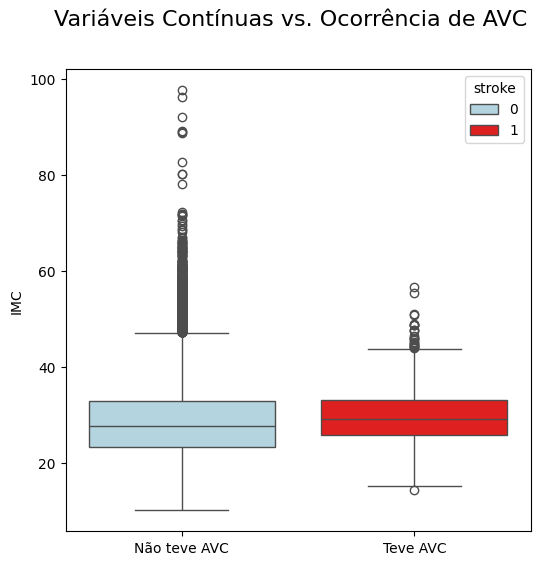

In [0]:
%python
import matplotlib.pyplot as plt
import seaborn as sns

# Ler os dados da camada Bronze
df_bronze_pd = spark.table(
    "mvpengenharia.bronze.stroke_dataset_bronze"
).select(
    "bmi", "stroke"
).toPandas()

# Confirguração e título
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.suptitle('Variáveis Contínuas vs. Ocorrência de AVC', fontsize=16)

# Boxplot bmi (IMC)
sns.boxplot(
    ax=ax,
    x="stroke",
    y="bmi",
    hue="stroke",
    data=df_bronze_pd,
    palette={0: 'lightblue', 1: 'red'}
)
ax.set_xlabel('')
ax.set_ylabel('IMC')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Não teve AVC', 'Teve AVC'])

plt.show()

A análise do boxplot de ***bmi*** revelou a presença de muitos outliers. A estratégia de imputação escolhida será preencher estes valores ausentes com a mediana, por ser uma medida mais robusta a valores extremos e, portanto, a mais indicada para não distorcer a distribuição original dos dados.

A coluna smoking_status apresentou uma quantidade massiva de linhas vazias, correspondendo a mais de 30% do dataset. Diante de um volume tão grande, a imputação com a moda foi descartada por introduzir um viés significativo nos dados. A exclusão das linhas acarretaria em uma grande perda de informação e a exclusão da coluna também não foi considerada, pois ela será utilizada para análise.

Logo, a decisão estratégica será imputar os valores vazios desta coluna com uma nova categoria: _**'unknown'**_. Essa abordagem tem a dupla vantagem de preservar todas as instâncias do dataset e, ao mesmo tempo, transformar a falta de informação em uma feature que contribuirá para análise final.

Abaixo será executado um comando para inputação da mediana para o **_bmi_** e a criação da categoria **_"Unknown"_** para _smoking_status_, preservando a integridade volumétrica da base. Também serão removidas as colunas de baixa relevância analítica (id, ever_married) e ocorrerá o ajuste da tipagem dos dados de idade para inteiro, truncando decimais, que são irrelevantes para o escopo.

Nas colunas restantes da nova tabela as descrições foram reaplicadas no Catálogo de Dados, garantindo que as regras de negócio aplicadas ficassem transparentes para os usuários finais.

In [0]:
%sql
CREATE OR REPLACE TABLE mvpengenharia.silver.stroke_dataset_silver
USING DELTA
COMMENT 'Camada Silver: Dados limpos, tipados e com nulos tratados via inputação. Colunas ID e Ever_Married removidas conforme premissas de negócio.'
AS
SELECT
  gender,
  cast(age as INT) as age, --Idades fracionadas foram truncadas pois a granularidade de meses não impacta a análise de AVC neste escopo
  -- cast(age as DOUBLE) as age,
  cast(hypertension as INT) as hypertension,
  cast(heart_disease as INT) as heart_disease,
  work_type,
  Residence_type,
  cast(avg_glucose_level as DOUBLE) as avg_glucose_level,
  
  -- Inputação do BMI pela Mediana
  COALESCE(bmi, (
      SELECT percentile_approx(bmi, 0.5) 
      FROM mvpengenharia.bronze.stroke_dataset_bronze
  )) as bmi,
  
  -- Inputação de Categoria Desconhecida em smoking_status
  COALESCE(smoking_status, 'Unknown') as smoking_status,
  
  cast(stroke as INT) as stroke,

  -- Linhagem
  current_timestamp() as silver_ingestion_date

FROM mvpengenharia.bronze.stroke_dataset_bronze;

-- Reaplicando as descrições nas colunas que restaram
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN gender COMMENT 'Gênero do paciente';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN age COMMENT 'Idade do paciente';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN hypertension COMMENT '0: Não hipertenso, 1: Hipertenso';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN heart_disease COMMENT '0: Sem doença cardíaca, 1: Com doença cardíaca';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN work_type COMMENT 'Categoria de tipo de trabalho';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN Residence_type COMMENT 'Tipo de residência (Rural/Urbana)';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN avg_glucose_level COMMENT 'Nível médio de glicose sanguínea';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN bmi COMMENT 'Índice de Massa Corporal (Nulos preenchidos com a Mediana)';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN smoking_status COMMENT 'Status de tabagismo (Nulos preenchidos como Unknown)';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN stroke COMMENT 'Target: 1 = AVC, 0 = Sem AVC';
ALTER TABLE mvpengenharia.silver.stroke_dataset_silver ALTER COLUMN silver_ingestion_date COMMENT 'Data de processamento da camada Silver';

In [0]:
%sql
-- Validação de Sanidade (Sanity Check)
SELECT 
  -- Deve retornar 0
  SUM(CASE WHEN bmi IS NULL THEN 1 ELSE 0 END) as check_nulos_bmi,
  -- Deve retornar 0
  SUM(CASE WHEN smoking_status IS NULL THEN 1 ELSE 0 END) as check_nulos_smoking,
  -- Verifica se existem valores impossíveis (ex: idade ou glicose negativa)
  MIN(age) as idade_minima,
  MIN(avg_glucose_level) as glicose_minima,
  -- Confirma o total de linhas final
  COUNT(*) as total_registros
FROM mvpengenharia.silver.stroke_dataset_silver;

check_nulos_bmi,check_nulos_smoking,idade_minima,glicose_minima,total_registros
0,0,0,55.0,43400


Por fim, o código acima execuita um Sanity Check para confirmar matematicamente a eliminação de valores nulos e verificar a consistência dos dados, assegurando que a camada Silver está pronta para alimentar a camada Gold.

In [0]:
%sql
SELECT * FROM mvpengenharia.silver.stroke_dataset_silver 
LIMIT 15;

gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,silver_ingestion_date
Male,3,0,0,children,Rural,95.12,18.0,Unknown,0,2025-12-13T20:43:30.882Z
Male,58,1,0,Private,Urban,87.96,39.2,never smoked,0,2025-12-13T20:43:30.882Z
Female,8,0,0,Private,Urban,110.89,17.6,Unknown,0,2025-12-13T20:43:30.882Z
Female,70,0,0,Private,Rural,69.04,35.9,formerly smoked,0,2025-12-13T20:43:30.882Z
Male,14,0,0,Never_worked,Rural,161.28,19.1,Unknown,0,2025-12-13T20:43:30.882Z
Female,47,0,0,Private,Urban,210.95,50.1,Unknown,0,2025-12-13T20:43:30.882Z
Female,52,0,0,Private,Urban,77.59,17.7,formerly smoked,0,2025-12-13T20:43:30.882Z
Female,75,0,1,Self-employed,Rural,243.53,27.0,never smoked,0,2025-12-13T20:43:30.882Z
Female,32,0,0,Private,Rural,77.67,32.3,smokes,0,2025-12-13T20:43:30.882Z
Female,74,1,0,Self-employed,Urban,205.84,54.6,never smoked,0,2025-12-13T20:43:30.882Z


Acima a tabela final da camada silver.